In [1]:
import dicom
import matplotlib.pyplot as plt

%matplotlib inline

from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd

Using TensorFlow backend.


In [2]:
dicom_files = [x for x in Path('./torso/rfmri/MR').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)

pig0 = dicom.read_file(str(dicom_files[22]), force=True)
im = pig0.pixel_array

In [3]:
# let's try loading the entire thing to ram
# the big tensor will have dimension [time, depth, height, width]

all_data = np.zeros((120, 47, im.shape[0], im.shape[1]))

for f in tqdm_notebook(dicom_files):
    pigfile = dicom.read_file(str(f), force=True)
    
    try:
    
        time = (pigfile.InstanceNumber - 1) // 47
        depth = pigfile.InStackPositionNumber - 1


        if np.count_nonzero(all_data[time, depth]) > 0:
            print('repeated stack position @ time %d , depth %d' % (time, depth))

        all_data[time, depth, ...] = pigfile.pixel_array
    except:
        print(f)
    

In [4]:
assert all_data.shape == (120, 47, 128, 128) # basic sanity check

In [5]:
import scipy.stats

scipy.stats.describe(all_data[0].flat)

DescribeResult(nobs=770048, minmax=(0.0, 5599.0), mean=377.42074000581783, variance=150212.03951245255, skewness=2.1149271851111107, kurtosis=5.985433753819269)

In [6]:
# use annotation to select pixels from volume
binary_mask = io.imread('./t0_bin_segment_v1.tif')
indices = np.nonzero(binary_mask)
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['depth', 'row', 'col'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    d, r, c = triple
    trace = all_data[:, d, r, c]
    series_df.loc[triple] = trace
    
data_block = np.vstack(series_df.values)[..., np.newaxis]
shuffled_data = np.copy(data_block)
np.random.shuffle(shuffled_data)
validation_set = shuffled_data[:1000]

In [7]:
from keras.models import load_model
m = load_model('e8_model.h5')

m.evaluate(validation_set, validation_set)

1000/1000 [==============================] - 3s     


2930.0694687499999

In [93]:

last_conv_layer_model = keras.models.Model(inputs=m.input,
                                 outputs=m.layers[14].output)
last_conv_activation_matrix = last_conv_layer_model.predict(data_block[:2000])



277.266666667
(2000, 15, 256)


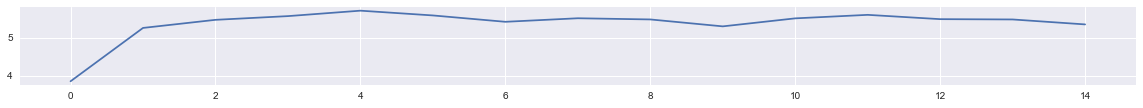

In [102]:
filter_1_activation_matrix = last_conv_activation_matrix[:,:,1]
filter_2_activation_matrix = last_conv_activation_matrix[:,:,2]

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(filter_1_activation_matrix[277,:]))

highest_1_act_map = filter_1_activation_matrix[277,:]
# highest_2_act_map = filter_1_activation_matrix[1948,:]
# highest_3_act_map = filter_1_activation_matrix[484,:]
# highest_4_act_map = filter_1_activation_matrix[1974,:]
# highest_5_act_map = filter_1_activation_matrix[248,:]
# highest_6_act_map = filter_1_activation_matrix[157,:]
# highest_7_act_map = filter_1_activation_matrix[293,:]
# highest_8_act_map = filter_1_activation_matrix[1949,:]
# highest_9_act_map = filter_1_activation_matrix[142,:]

new_filter_1_activation_matrix = np.array(filter_1_activation_matrix, copy=True)
# new_filter_1_activation_matrix[277] = np.zeros(30)
# new_filter_1_activation_matrix[1948] = np.zeros(30)
# new_filter_1_activation_matrix[484] = np.zeros(30)
# new_filter_1_activation_matrix[1974] = np.zeros(30)
# new_filter_1_activation_matrix[248] = np.zeros(30)
# new_filter_1_activation_matrix[157] = np.zeros(30)
# new_filter_1_activation_matrix[293] = np.zeros(30)
# new_filter_1_activation_matrix[1949] = np.zeros(30)
# new_filter_1_activation_matrix[142] = np.zeros(30)

#print(new_filter_1_activation_matrix.shape)
print(np.argmax(filter_1_activation_matrix)/15)
# print(np.argmax(new_filter_1_activation_matrix)/30)

print(last_conv_activation_matrix.shape)




In [105]:
print(m.layers[15].get_config())

{'name': 'conv1d_5', 'trainable': True, 'filters': 256, 'kernel_size': (3,), 'strides': (1,), 'padding': 'causal', 'dilation_rate': (1,), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


(2000, 15, 256)
(15, 256)
(1, 120, 1)


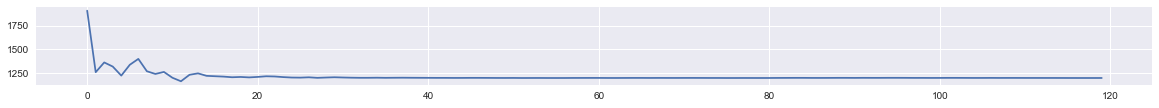

In [128]:

print(last_conv_activation_matrix.shape)
alice = last_conv_activation_matrix[277,:,:]
alice = np.zeros((15, 256))
alice[:, 1] = last_conv_activation_matrix[277,:,1]
print(alice.shape)
alice = alice.reshape((1,15,256))


def model(m):
    from keras.layers.convolutional import Conv1D, UpSampling1D
    from keras.layers.pooling import MaxPooling1D
    from keras.layers.core import Dense, Activation
    from keras.layers import Input
    from keras.layers.normalization import BatchNormalization
    import keras.backend as K
    
    model1 = K.function([m.layers[15].input, K.learning_phase()],
                                  [m.layers[30].output])

    return model1

deconv_model = model(m)
alice_deconv = deconv_model([alice, 0])
print(alice_deconv[0].shape)

# print(alice_deconv.shape)
plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(alice_deconv))






In [82]:
deconv_model.layers

Tensor("conv1d_2/add:0", shape=(?, 120, 64), dtype=float32)


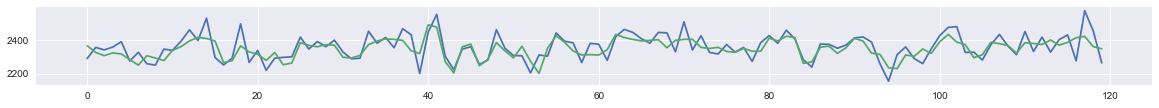

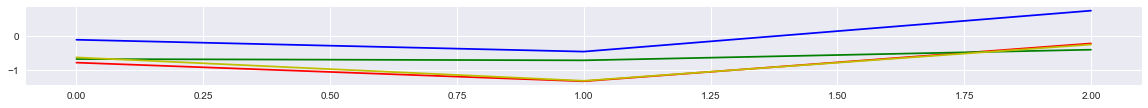

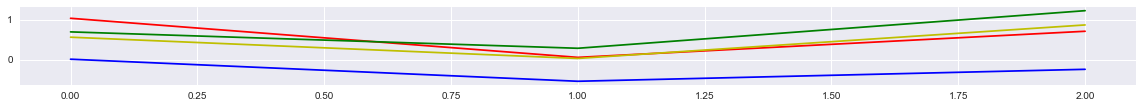

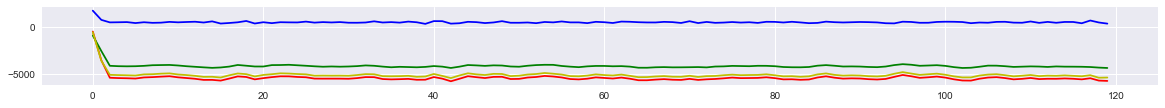

In [52]:
from keras import backend as K
layer = m.get_layer(index=1)

sample_1 = data_block[np.newaxis, 1000]
recon_1 = m.predict(sample_1)

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(np.squeeze(sample_1))
plt.plot(np.squeeze(recon_1))

weight_1 = layer.get_weights()[0][0][0]
weight_2 = layer.get_weights()[0][1][0]
weight_3 = layer.get_weights()[0][2][0]

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot([weight_1[0], weight_2[0], weight_3[0]], c='r')
plt.plot([weight_1[1], weight_2[1], weight_3[1]], c='g')
plt.plot([weight_1[2], weight_2[2], weight_3[2]], c='b')
plt.plot([weight_1[3], weight_2[3], weight_3[3]], c='y')

layer2 = m.get_layer(index=4)

weight_1 = layer2.get_weights()[0][0][0]
weight_2 = layer2.get_weights()[0][1][0]
weight_3 = layer2.get_weights()[0][2][0]

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot([weight_1[0], weight_2[0], weight_3[0]], c='r')
plt.plot([weight_1[1], weight_2[1], weight_3[1]], c='g')
plt.plot([weight_1[2], weight_2[2], weight_3[2]], c='b')
plt.plot([weight_1[3], weight_2[3], weight_3[3]], c='y')


remember_output = layer2.output
output_1 = m.predict(sample_1)
print(remember_output)

get_4th_layer_output = K.function([m.get_layer(index=0).input, K.learning_phase()],
                                  [m.get_layer(index=1).output])
layer_output = get_4th_layer_output([sample_1, 0])[0]

plt.figure(figsize=(20, 10))
plt.subplot(611)
plt.plot(layer_output[0,:,0], c='r')
plt.plot(layer_output[0,:,1], c='g')
plt.plot(layer_output[0,:,2], c='b')
plt.plot(layer_output[0,:,3], c='y')


{'name': 'max_pooling1d_3', 'trainable': True, 'strides': (2,), 'pool_size': (2,), 'padding': 'valid'}
(13550, 120, 1)
(2000, 15, 256)
(2000, 3840)
(2000, 2)


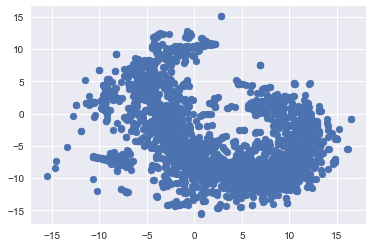

In [61]:
from sklearn import manifold
from time import time

embedding_model = keras.models.Model(inputs=m.input,
                                 outputs=m.layers[14].output)
embeddings = embedding_model.predict(data_block[:2000])

squished_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))

print(m.layers[14].get_config())
print(data_block.shape)
print(embeddings.shape)
print(squished_embeddings.shape)

tsne_50 = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=50)
tsne_50_result = tsne_50.fit_transform(squished_embeddings)
plt.scatter(tsne_50_result[:, 0], tsne_50_result[:, 1])

# tsne_100 = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=100)
# tsne_100_result = tsne_100.fit_transform(squished_embeddings)
# plt.scatter(tsne_100_result[:, 0], tsne_100_result[:, 1])

print(tsne_50_result.shape)


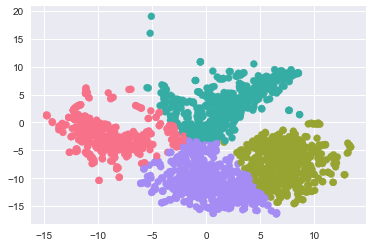

In [50]:
# color (kmeans) and label
from sklearn.cluster import KMeans
qualitative_clusters = 4

my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=10)

rgbs = [np.array(c) for c in sns.color_palette("husl", qualitative_clusters)]

my_kmeans.fit(tsne_50_result)
labels = my_kmeans.labels_

colors = [rgbs[i] for i in labels]

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors)


In [53]:
indices_for_group_1 = np.where(labels == 1)[0]
indices_for_group_2 = np.where(labels == 2)[0]
indices_for_group_3 = np.where(labels == 3)[0]

{'name': 'max_pooling1d_3', 'trainable': True, 'strides': (2,), 'pool_size': (2,), 'padding': 'valid'}
(13550, 120, 1)
(2000, 15, 256)
(2000, 3840)
(2000, 2)
